<a href="https://colab.research.google.com/github/doruktopcu/BTK_Introduction_to_Natural_Language_Processing/blob/main/Train_Models_on_Full_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Test and Train all models

In [ ]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 16.5 MB/s eta 0:00:00


In [ ]:
pip install scikeras

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report, roc_curve, auc)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, label_binarize, OneHotEncoder

# Estimators
import xgboost as xgb
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
import lightgbm as lgb

# Keras for CNN
from keras.layers import Conv1D, Dense, Flatten, Dropout, MaxPooling1D
from keras.models import Sequential
from keras.optimizers import Adam

# Utilities
import joblib

# ----------------------------
# (OPTIONAL) For multi-class ROC plotting
from sklearn.preprocessing import LabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
# ----------------------------


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
def filter_classes(df, min_count=10):
    """
    Filters out 'Antibiotic' classes with fewer than `min_count` samples.
    """
    class_counts = df['Antibiotic'].value_counts()
    to_keep = class_counts[class_counts >= min_count].index
    return df[df['Antibiotic'].isin(to_keep)]

def encode_features(df):
    """
    1) 2-gram char-based CountVectorizer for GSequence
    2) 1-gram char-based CountVectorizer for AMR
    3) LabelEncoder for Antibiotic
    4) Concatenate encoded features into X, return y
    """
    # 2-gram encoding for GSequence
    vectorizer_seq = CountVectorizer(analyzer='char', ngram_range=(2, 2))
    X_seq = vectorizer_seq.fit_transform(df['GSequence'])

    # 1-gram encoding for AMR
    vectorizer_amr = CountVectorizer(analyzer='char', ngram_range=(1, 1))
    X_amr = vectorizer_amr.fit_transform(df['AMR'])

    # Label encoding for Antibiotic

    le = LabelEncoder()
    y = le.fit_transform(df['Antibiotic'])

    # Convert sparse matrices to DataFrames
    X_seq_df = pd.DataFrame(X_seq.toarray(), columns=vectorizer_seq.get_feature_names_out())
    X_amr_df = pd.DataFrame(X_amr.toarray(), columns=vectorizer_amr.get_feature_names_out())

    # Concatenate features
    X = pd.concat([X_seq_df, X_amr_df], axis=1)
    return X, y, vectorizer_seq, vectorizer_amr, le


In [ ]:
input_dim = None
num_classes = None

def build_cnn_model(filters=32, filters_2=64, kernel_size=3, pool_size=2,
                    dropout_rate=0.2, learning_rate=0.001, **kwargs):
    """
    Build a simple 1D CNN for multi-class classification.
    """
    global input_dim, num_classes

    model = Sequential()
    # 1st Conv + Pool
    model.add(Conv1D(filters=filters,
                     kernel_size=kernel_size,
                     activation='relu',
                     input_shape=(input_dim, 1)))
    model.add(MaxPooling1D(pool_size=pool_size))

    # 2nd Conv + Pool
    model.add(Conv1D(filters=filters_2,
                     kernel_size=kernel_size,
                     activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))

    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [ ]:
print("Loading and preprocessing data...")

df = pd.read_excel("/content/drive/MyDrive/Doruk Combined Data/combined_dataset_cleaned_retagged_excel_3.xlsx")
df = filter_classes(df)
X, y, vectorizer_seq, vectorizer_amr, label_encoder = encode_features(df)

# Update global variables for CNN
input_dim = X.shape[1]
num_classes = len(label_encoder.classes_)


best_params = {
    'XGBoost':    {'learning_rate': 0.1, 'n_estimators': 700},
    'SVM':        {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'},
    'CatBoost':   {'iterations': 500, 'learning_rate': 0.1, 'verbose': 0},
    'LogReg':     {'C': 1, 'max_iter': 1000, 'solver': 'lbfgs'},
    'KNN':        {'n_neighbors': 3, 'p': 2, 'weights': 'distance'},
    'RandomForest': {'max_depth': None, 'n_estimators': 300},
    'GradientBoosting': {'learning_rate': 0.01, 'n_estimators': 500},
    'NaiveBayes': {'alpha': 0.1},
    'LightGBM':   {'learning_rate': 0.01, 'n_estimators': 700},
    'CNN':        {'batch_size': 32, 'epochs': 10, 'filters': 32, 'filters_2': 64,
                   'kernel_size': 3, 'learning_rate': 0.001, 'pool_size': 2}
}

def get_model(name, params):
    """
    Returns an instance of the model based on `name` and `params`.
    For CNN, we return None because we'll build it separately.
    """
    if name == 'XGBoost':
        return xgb.XGBClassifier(**params)
    elif name == 'SVM':
        return SVC(probability=True, **params)
    elif name == 'CatBoost':
        return CatBoostClassifier(**params)
    elif name == 'LogReg':
        return LogisticRegression(**params)
    elif name == 'KNN':
        return KNeighborsClassifier(**params)
    elif name == 'RandomForest':
        return RandomForestClassifier(**params)
    elif name == 'GradientBoosting':
        return GradientBoostingClassifier(**params)
    elif name == 'NaiveBayes':
        return MultinomialNB(**params)
    elif name == 'LightGBM':
        return lgb.LGBMClassifier(**params)
    else:
        return None


Loading and preprocessing data...


In [ ]:
# Create an output folder (if it doesn’t exist already)
output_folder = "/content/drive/MyDrive/Doruk Combined Data/models_trained_on_all_data_test"
os.makedirs(output_folder, exist_ok=True)

# We'll store comparison metrics for each model in a list of dicts
comparison_results = []
# We'll store per-class recall in a dict of dicts, so we can build a DF later
per_class_recall_dict = {}

model_names = ["XGBoost", "SVM", "CatBoost", "LogReg", "KNN",
               "RandomForest", "GradientBoosting", "NaiveBayes",
               "LightGBM", "CNN"]

for model_name in model_names:
    print(f"\nTraining: {model_name}")
    params = best_params[model_name]

    if model_name != 'CNN':
        # Traditional sklearn model
        clf = get_model(model_name, params)
        clf.fit(X, y)

        # Save model using joblib
        joblib.dump(clf, os.path.join(output_folder, f"{model_name}.pkl"))

    else:
        # CNN case
        # Reshape data for CNN: (samples, features, 1)
        X_train_cnn = X.values.reshape(-1, X.shape[1], 1)

        # Build and train
        cnn_model = build_cnn_model(**params)
        epochs = params.get('epochs', 10)
        batch_size = params.get('batch_size', 32)

        cnn_model.fit(X_train_cnn, y,
                      epochs=epochs,
                      batch_size=batch_size,
                      verbose=1)


        # Save CNN in two formats
        cnn_model.save(os.path.join(output_folder, f"{model_name}.h5"))
        # Keras models are not always fully serializable with joblib,
        # but here's the requested approach:
        joblib.dump(cnn_model, os.path.join(output_folder, f"{model_name}.pkl"))




Training: XGBoost

Training: SVM

Training: CatBoost

Training: LogReg

Training: KNN

Training: RandomForest

Training: GradientBoosting

Training: NaiveBayes

Training: LightGBM
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3930
[LightGBM] [Info] Number of data points in the train set: 21824, number of used features: 448
[LightGBM] [Info] Start training from score -2.355462
[LightGBM] [Info] Start training from score -6.812712
[LightGBM] [Info] Start training from score -2.805379
[LightGBM] [Info] Start training from score -1.856298
[LightGBM] [Info] Start training from score -1.135530
[LightGBM] [Info] Start training from score -3.906266
[LightGBM] [Info] Start training from score -7.218177
[LightGBM] [Info] Start training from score -3.744659
[LightGBM] [Info] Start training 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
682/682 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8396 - loss: 0.6183
Epoch 2/10
682/682 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9816 - loss: 0.0683
Epoch 3/10
682/682 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9889 - loss: 0.0349
Epoch 4/10
682/682 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9938 - loss: 0.0194
Epoch 5/10
682/682 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9955 - loss: 0.0163
Epoch 6/10
682/682 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9941 - loss: 0.0157
Epoch 7/10
682/682 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9969 - loss: 0.0114
Epoch 8/10
682/682 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9973 - loss: 0.0087
Epoch 9/10
682/682 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9961 - loss: 0.0115
Epoch 10/10
682/682 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9981 - loss: 0.0066


In [ ]:
joblib.dump(vectorizer_seq, os.path.join(output_folder, "vectorizer_seq.pkl"))

['/content/drive/MyDrive/Doruk Combined Data/models_trained_on_all_data_test/vectorizer_seq.pkl']

In [ ]:
joblib.dump(label_encoder, os.path.join(output_folder, "label_encoder.pkl"))

['/content/drive/MyDrive/Doruk Combined Data/models_trained_on_all_data_test/label_encoder.pkl']

In [ ]:
joblib.dump(vectorizer_amr, os.path.join(output_folder, "vectorizer_amr.pkl"))

['/content/drive/MyDrive/Doruk Combined Data/models_trained_on_all_data_test/vectorizer_amr.pkl']

In [ ]:

def get_verdict(prob):
    if prob >= 0.8:
        return "High chance of Resistance (Resistant)"
    elif prob >= 0.6:
        return "Moderate Chance of Resistance (Potentially Resistant)"
    elif prob >= 0.4:
        return "Low Chance of Resistance (Potentially Susceptible)"
    else:
        return "Unlikely Resistance (Susceptible)"

def preprocess_single_sequence(sequence, vectorizer, all_cols):
    seq_transformed = vectorizer.transform([sequence])
    seq_df = pd.DataFrame(seq_transformed.toarray(), columns=vectorizer.get_feature_names_out())
    seq_full = pd.DataFrame(0, index=[0], columns=all_cols)
    seq_full.update(seq_df)
    return seq_full

def predict_single_sequence(sequence,
                            model,
                            vectorizer,
                            label_encoder,
                            all_cols,
                            is_cnn=False):
    # Preprocess
    seq_df = preprocess_single_sequence(sequence, vectorizer, all_cols)

    if is_cnn:
        arr = seq_df.values.reshape(seq_df.shape[0], seq_df.shape[1], 1)
        y_prob = model.predict(arr)  # (1, num_classes)
        y_pred = np.argmax(y_prob, axis=1)
    else:
        y_pred = model.predict(seq_df)
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(seq_df)  # (1, num_classes)
        else:
            # fallback
            n_classes = len(label_encoder.classes_)
            y_prob = np.zeros((1,n_classes))

    # Decode
    decoded_label = label_encoder.inverse_transform(y_pred)  # e.g. ["Amikacin"]

    # Build probabilities dict
    prob_dict = {
        label_encoder.classes_[i]: p
        for i, p in enumerate(y_prob[0])
    }
    prob_dict_sorted = dict(sorted(prob_dict.items(), key=lambda x: x[1], reverse=True))
    return decoded_label[0], prob_dict_sorted

def create_antibiogram_for_sequence(single_sequence,
                                    best_per_class,
                                    models_dict,
                                    vectorizer,
                                    label_encoder,
                                    all_columns,
                                    output_folder):
    """
    For each antibiotic class, pick the 'best model' from best_per_class,
    get the probability, decide verdict, save results + infographic.
    """
    # Ensure folder
    os.makedirs(output_folder, exist_ok=True)

    antibiogram_data = []
    for antibiotic_class, best_model_name in best_per_class.items():
        model = models_dict[best_model_name]
        # CNN check
        is_cnn = (best_model_name == "CNN")

        pred_label, sorted_probs = predict_single_sequence(
            single_sequence,
            model,
            vectorizer,
            label_encoder,
            all_columns,
            is_cnn=is_cnn
        )
        # Probability for the antibiotic_class of interest
        prob_resistance = sorted_probs.get(antibiotic_class, 0.0)
        verdict = get_verdict(prob_resistance)

        antibiogram_data.append({
            "Antibiotic": antibiotic_class,
            "Probability": prob_resistance,
            "Verdict": verdict
        })

    # Maybe a comment if all are high or all low
    if all(d["Probability"] >= 0.7 for d in antibiogram_data):
        comment = "Pathogen may be Multi-Drug Resistant"
    elif all(d["Probability"] < 0.3 for d in antibiogram_data):
        comment = "Pathogen may be Susceptible to Most Antibiotics"
    else:
        comment = "Mixed Resistance Profile"

    abi_df = pd.DataFrame(antibiogram_data).sort_values("Probability", ascending=False)
    abi_df["Comment"] = ""
    if not abi_df.empty:
        abi_df.at[abi_df.index[0], "Comment"] = comment

    # Save Excel
    abi_path = os.path.join(output_folder, "test_antibiogram_single_sequence.xlsx")
    abi_df.to_excel(abi_path, index=False)
    print(f"[INFO] Single-sequence antibiogram saved to {abi_path}")

    # Create infographic
    create_antibiogram_infographic(abi_df, output_folder)

def create_antibiogram_infographic(antibiogram_df, output_folder):
    if antibiogram_df.empty:
        print("No data to visualize.")
        return

    fig = plt.figure(figsize=(20,15))
    grid = plt.GridSpec(3,2, wspace=0.3, hspace=0.5)

    sorted_df = antibiogram_df.copy()

    # 1) Bar Chart
    ax1 = fig.add_subplot(grid[0, :])
    colors = sns.color_palette("coolwarm", len(sorted_df))
    ax1.bar(sorted_df["Antibiotic"], sorted_df["Probability"], color=colors)
    ax1.set_title("Resistance Probability by Antibiotic Class (Single Sequence)", fontsize=16)
    ax1.set_ylabel("Probability", fontsize=14)
    ax1.set_xticks(range(len(sorted_df)))
    ax1.set_xticklabels(sorted_df["Antibiotic"], rotation=45, ha='right', fontsize=12)
    ax1.axhline(0.9, color='red', linestyle='--', label='High Threshold')
    ax1.axhline(0.3, color='green', linestyle='--', label='Low Threshold')
    ax1.legend(fontsize=12)

    # 2) Heatmap
    ax2 = fig.add_subplot(grid[1,0])
    hm_data = sorted_df[["Antibiotic","Probability"]].set_index("Antibiotic")
    sns.heatmap(hm_data, annot=True, fmt=".2f", cmap="YlOrRd", linewidths=0.5, ax=ax2, cbar_kws={"label":"Probability"})
    ax2.set_title("Heatmap of Predictions", fontsize=16)
    ax2.set_ylabel("Antibiotic Class", fontsize=14)

    # 3) Pie Chart
    ax3 = fig.add_subplot(grid[1,1])
    verdict_counts = sorted_df["Verdict"].value_counts()
    pie_colors = sns.color_palette("Set2", len(verdict_counts))
    ax3.pie(
        verdict_counts,
        labels=verdict_counts.index,
        autopct="%1.1f%%",
        startangle=90,
        colors=pie_colors,
        wedgeprops={"edgecolor":"black"}
    )
    ax3.set_title("Distribution of Verdicts", fontsize=16)

    # 4) Text highlight
    ax4 = fig.add_subplot(grid[2, :])
    most_resistant = sorted_df.iloc[0]
    most_susceptible = sorted_df.iloc[-1]
    resistant_text = (f"Most Resistant: {most_resistant['Antibiotic']}\n"
                      f"Probability: {most_resistant['Probability']:.2f}")
    susceptible_text = (f"Most Susceptible: {most_susceptible['Antibiotic']}\n"
                        f"Probability: {most_susceptible['Probability']:.2f}")
    ax4.text(
        0.25, 0.5, resistant_text,
        fontsize=14, color='red', ha='center', va='center',
        bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.5')
    )
    ax4.text(
        0.75, 0.5, susceptible_text,
        fontsize=14, color='green', ha='center', va='center',
        bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.5')
    )
    ax4.set_axis_off()

    plt.suptitle("Antibiogram Infographic - Single Sequence", fontsize=20, fontweight='bold')
    save_path = os.path.join(output_folder, "antibiogram_infographic_single_sequence.png")
    plt.savefig(save_path, dpi=400, bbox_inches='tight')
    plt.show()
    print(f"[INFO] Antibiogram infographic saved to {save_path}")

In [ ]:
#load all models from exported folder "models3"
LogReg = joblib.load('/content/drive/MyDrive/Doruk Combined Data/models_trained_on_all_data_test/LogReg.pkl')
XGBoost = joblib.load('/content/drive/MyDrive/Doruk Combined Data/models_trained_on_all_data_test/XGBoost.pkl')
NaiveBayes = joblib.load('/content/drive/MyDrive/Doruk Combined Data/models_trained_on_all_data_test/NaiveBayes.pkl')
KNN = joblib.load('/content/drive/MyDrive/Doruk Combined Data/models_trained_on_all_data_test/KNN.pkl')
SVM = joblib.load('/content/drive/MyDrive/Doruk Combined Data/models_trained_on_all_data_test/SVM.pkl')
RandomForest = joblib.load('/content/drive/MyDrive/Doruk Combined Data/models_trained_on_all_data_test/RandomForest.pkl')
GradientBoost = joblib.load('/content/drive/MyDrive/Doruk Combined Data/models_trained_on_all_data_test/GradientBoosting.pkl')
CatBoost = joblib.load('/content/drive/MyDrive/Doruk Combined Data/models_trained_on_all_data_test/CatBoost.pkl')
LightGBM = joblib.load('/content/drive/MyDrive/Doruk Combined Data/models_trained_on_all_data_test/LightGBM.pkl')
CNN = joblib.load('/content/drive/MyDrive/Doruk Combined Data/models_trained_on_all_data_test/CNN.pkl')

#load vectorizers
vectorizer_seq = joblib.load('/content/drive/MyDrive/Doruk Combined Data/models_trained_on_all_data_test/vectorizer_seq.pkl')
vectorizer_amr = joblib.load('/content/drive/MyDrive/Doruk Combined Data/models_trained_on_all_data_test/vectorizer_amr.pkl')
label_encoder = joblib.load('/content/drive/MyDrive/Doruk Combined Data/models_trained_on_all_data_test/label_encoder.pkl')
all_columns = joblib.load('/content/drive/MyDrive/Doruk Combined Data/models_trained_on_all_data_test/all_columns.pkl')

models = {
    'LogisticRegression': LogReg,
    'XGBoost': XGBoost,
    'NaiveBayes': NaiveBayes,
    'KNN': KNN,
    'SVM': SVM,
    'RandomForest': RandomForest,
    'GradientBoosting': GradientBoost,
    'CatBoost': CatBoost,
    'LightGBM': LightGBM,
    'CNN': CNN
}



/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
best_model_per_class = {
    "MLS": "SVM",
    "aminocoumarin": "NaiveBayes",
    "aminoglycoside": "LightGBM",
    "bacitracin": "CatBoost",
    "beta-lactam": "CNN",
    "chloramphenicol": "CatBoost",
    "elfamycin": "NaiveBayes",
    "fosfomycin": "KNN",
    "fusidic acid": "LightGBM",
    "glycopeptide": "CatBoost",
    "kasugamycin": "NaiveBayes",
    "multidrug": "CNN",
    "mupirocin": "KNN",
    "nitroimidazole": "NaiveBayes",
    "peptide": "KNN",
    "polymyxin": "KNN",
    "qa compound": "KNN",
    "quinolone": "LogisticRegression",
    "rifamycin": "CNN",
    "streptothricin": "XGBoost",
    "sulfonamide": "CatBoost",
    "tetracycline": "CatBoost",
    "trimethoprim": "XGBoost"
}

In [ ]:
def get_verdict(probability):
    if probability >= 0.8:
        return "High chance of Resistance(Resistant)"
    elif probability >= 0.6:
        return "Moderate Chance of Resistance(Potential Resistant)"
    elif probability >= 0.4:
        return "Low Chance of Resistance(Potential Susceptible)"
    else:
        return "Unlikely Resistance(Susceptible)"

def preprocess_single_sequence(sequence, vectorizer_seq, vectorizer_amr, all_columns):
    # Vectorize the single sequence (assuming the sequence is a string like GSequence)
    sequence_transformed = vectorizer_seq.transform([sequence])
    sequence_encoded = pd.DataFrame(sequence_transformed.toarray(), columns=vectorizer_seq.get_feature_names_out())

    # Create a full DataFrame of zeros for all_columns
    sequence_full = pd.DataFrame(0, index=np.arange(1), columns=all_columns)
    sequence_full.update(sequence_encoded)

    return sequence_full

def preprocess_for_cnn_gru_single(X):
    # If X is a DataFrame, convert to numpy array
    if isinstance(X, pd.DataFrame):
        X = X.values
    # Reshape to (num_samples, num_features, 1)
    X = X.reshape(X.shape[0], X.shape[1], 1)
    return X

def predict_single_sequence(sequence, model, vectorizer_seq, vectorizer_amr, label_encoder, all_columns, is_cnn=False):
    # Preprocess the sequence
    sequence_full = preprocess_single_sequence(sequence, vectorizer_seq, vectorizer_amr, all_columns)

    # If CNN model, apply the CNN-specific preprocessing
    if is_cnn:
        sequence_full_processed = preprocess_for_cnn_gru_single(sequence_full)
        prediction_prob = model.predict(sequence_full_processed)  # CNN often outputs probabilities
        prediction = np.argmax(prediction_prob, axis=1)
    else:
        # Non-CNN model, directly predict on sequence_full
        prediction = model.predict(sequence_full)
        prediction_prob = model.predict_proba(sequence_full)

    prediction_label = label_encoder.inverse_transform(prediction)
    class_probabilities = {label_encoder.classes_[i]: prob for i, prob in enumerate(prediction_prob[0])}
    sorted_probabilities = dict(sorted(class_probabilities.items(), key=lambda item: item[1], reverse=True))

    return prediction_label[0], sorted_probabilities

# Enter a FASTA sequence here.

single_sequence = """MSNYIIETKNLTKQYGEQKSVANLSIHVRKGSIYGLLGRNGAGKTTTMKMLLGLTKPTLGEAKIFNQDIK
NDMKSILPRVGSLIESPGFYPNLTGTENLKIFARLRGVPNQEAVRNVLDLVGLPYNDKKLFSQYSLGMKQ
RLAIALTLMHDPEVIILDEPINGLDPIGIAEIRSFIRDLCDKQGKTILISSHILSEIEQLADDIGIINNG
ELLEEGSLEELKQKNNKYIHFIVSNTSEAALILENDFQISDFQIIDNRQLKIYDTSLSVATINRTFILRD
LEVSEARLQEDTLEDYFKRVTGGVGIA"""
antibiogram_data = []

for antibiotic_class, model_name in best_model_per_class.items():
    model = models[model_name]
    # Check if model_name is 'CNN' to apply CNN preprocessing
    is_cnn = (model_name == 'CNN')

    prediction_label, sorted_probabilities = predict_single_sequence(
        single_sequence,
        model,
        vectorizer_seq,
        vectorizer_amr,
        label_encoder,
        all_columns,
        is_cnn=is_cnn
    )

    # Find the antibiotic class probability
    probability = sorted_probabilities.get(antibiotic_class, 0.0)
    verdict = get_verdict(probability)

    antibiogram_data.append({
        'Antibiotic': antibiotic_class,
        'Probability': probability,
        'Verdict': verdict
    })

# Check if all probabilities are greater than 0, sequence may be multidrug resistant
if all(prob > 0 for prob in sorted_probabilities.values()):
    comment = "Pathogen may be Multidrug Resistant"
elif all(prob == 0 for prob in sorted_probabilities.values()):
    comment = "Organism may be susceptible to all antibiotics"
else:
    comment = "Pathogen may be susceptible to some antibiotics"
print("\nAntibiogram Comment:", comment)

# Create a DataFrame from the antibiogram data
antibiogram_df = pd.DataFrame(antibiogram_data).sort_values(by='Probability', ascending=False)

print("Antibiogram based on the best model per antibiotic class:")
print(antibiogram_df)

# Add a comment row to the DataFrame
comment_row = pd.DataFrame([[comment] + [None] * (len(antibiogram_df.columns))],
                           columns=['Comment'] + list(antibiogram_df.columns))

antibiogram_df_with_comment = pd.concat([comment_row, antibiogram_df], ignore_index=True)

# Save the antibiogram to an Excel file
antibiogram_df.to_excel('antibiogram_results.xlsx', index=False)
print("\nAntibiogram saved to antibiogram_results.xlsx")


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Antibiogram Comment: Pathogen may be Multidrug Resistant
Antibiogram based on the best model per antibiotic class:
         Antibiotic    Probability                               Verdict
11        multidrug   9.227321e-01  High chance of Resistance(Resistant)
0               MLS   3.709429e-02      Unlikely Resistance(Susceptible)
9      glycopeptide   1.905964e-02      Unlikely Resistance(Susceptible)
21     tetracycline   1.482416e-02      Unlikely Resistance(Susceptible)
3        bacitracin   1.407330e-02      Unlikely Resistance(Susceptible)
5   chloramphenicol   7.424922e-03      Unlikely Resistance(Susceptible)
20      sulfonamide   4.258472e-03      Unlikely Resistance(Susceptible)
2    aminoglycoside   3.816993e-03      Unlikely Resistance(Susceptible)
19   streptothricin   3.553767e-03      Unlikely Resistance(Susceptible)
22     trimethoprim   3.514375e-03      Unlikely Resistance(Susceptible)
4       beta-lactam   1.579763e-03      Unlikely Resistance(Susceptible)
17      

<ipython-input-36-67af34b94438>:103: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  antibiogram_df_with_comment = pd.concat([comment_row, antibiogram_df], ignore_index=True)


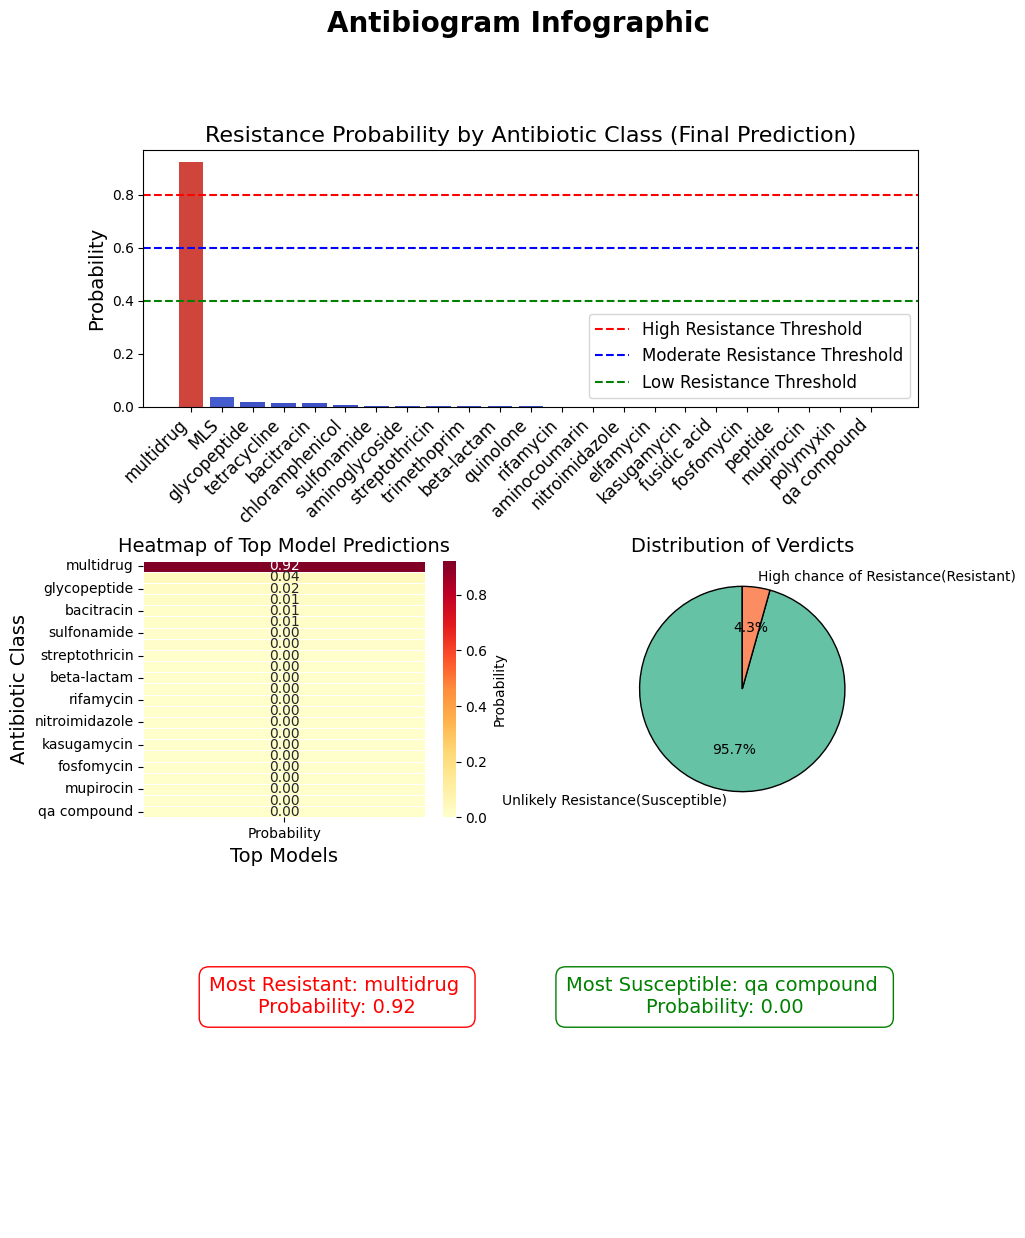

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Load the antibiogram results
antibiogram_df = pd.read_excel('antibiogram_results.xlsx')

# Set up the figure grid
fig = plt.figure(figsize=(10, 14))
grid = plt.GridSpec(3, 2, wspace=0.2, hspace=0.6)

# --- 1. Bar Chart: Top Model Predictions ---
ax1 = fig.add_subplot(grid[0, :])
sorted_df = antibiogram_df.sort_values(by='Probability', ascending=False)
colors = sns.color_palette("coolwarm", as_cmap=True)(sorted_df['Probability'])

ax1.bar(sorted_df['Antibiotic'], sorted_df['Probability'], color=colors)
ax1.set_title('Resistance Probability by Antibiotic Class (Final Prediction)', fontsize=16)
ax1.set_ylabel('Probability', fontsize=14)
ax1.set_xticks(range(len(sorted_df)))
ax1.set_xticklabels(sorted_df['Antibiotic'], rotation=45, ha='right', fontsize=12)
ax1.axhline(0.8, color='red', linestyle='--', label='High Resistance Threshold')
ax1.axhline(0.6, color='blue', linestyle='--', label='Moderate Resistance Threshold')
ax1.axhline(0.4, color='green', linestyle='--', label='Low Resistance Threshold')
ax1.legend(fontsize=12)

# --- 2. Heatmap: Top 2 Models ---
ax2 = fig.add_subplot(grid[1, 0])
heatmap_data = sorted_df[['Antibiotic', 'Probability']].set_index('Antibiotic')
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap="YlOrRd",
    linewidths=0.5,
    ax=ax2,
    cbar_kws={"label": "Probability"}
)
ax2.set_title('Heatmap of Top Model Predictions', fontsize=14)
ax2.set_xlabel('Top Models', fontsize=14)
ax2.set_ylabel('Antibiotic Class', fontsize=14)

# --- 3. Pie Chart: Verdict Distribution ---
ax3 = fig.add_subplot(grid[1, 1])
verdict_counts = sorted_df['Verdict'].value_counts()
colors = sns.color_palette("Set2", len(verdict_counts))
ax3.pie(
    verdict_counts,
    labels=verdict_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    wedgeprops={'edgecolor': 'black'}
)
ax3.set_title('Distribution of Verdicts', fontsize=14)

# --- 4. Highlight: Most Resistant & Susceptible ---
ax4 = fig.add_subplot(grid[2, :])
most_resistant = sorted_df.iloc[0]
most_susceptible = sorted_df.iloc[-1]

resistant_text = f"Most Resistant: {most_resistant['Antibiotic']} \nProbability: {most_resistant['Probability']:.2f}"
susceptible_text = f"Most Susceptible: {most_susceptible['Antibiotic']} \nProbability: {most_susceptible['Probability']:.2f}"

ax4.text(0.25, 0.9, resistant_text, fontsize=14, color='red', ha='center', va='center', bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.5'))
ax4.text(0.75, 0.9, susceptible_text, fontsize=14, color='green', ha='center', va='center', bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.5'))
ax4.set_axis_off()

# Show the complete infographic
plt.suptitle('Antibiogram Infographic', fontsize=20, fontweight='bold')
plt.show()

In [ ]:
# prompt: test all the models, create classification reports, use X as the test set entirely and y as the target, use label encoder to show names of antibiotics in classification report

from sklearn.metrics import classification_report

# Assuming X and y are already defined and preprocessed

# Create a dictionary to store classification reports for each model
classification_reports = {}

for model_name, model in models.items():
    # Predict using the current model
    if model_name == 'CNN':
        X_processed = preprocess_for_cnn_gru_single(X)
        y_pred = model.predict(X_processed)
        y_pred = np.argmax(y_pred, axis=1) # Take the class with the highest probability
    else:
        y_pred = model.predict(X)

    # Inverse transform the predicted labels back to antibiotic names
    y_pred_decoded = label_encoder.inverse_transform(y_pred)
    y_true_decoded = label_encoder.inverse_transform(y)

    # Generate and store the classification report
    report = classification_report(y_true_decoded, y_pred_decoded)
    classification_reports[model_name] = report

# Print the classification reports for each model
for model_name, report in classification_reports.items():
    print(f"Classification Report for {model_name}:\n{report}\n")

NameError: name 'X' is not defined

In [ ]:
# prompt: export all classification reports to a folder in drive

from google.colab import drive
drive.mount('/content/drive')

import os

# Specify the folder path in Google Drive where you want to save the reports
reports_folder = "/content/drive/MyDrive/AllModelsOnData/classification_reports"

# Create the folder if it doesn't exist
if not os.path.exists(reports_folder):
    os.makedirs(reports_folder)

# Iterate through the classification_reports dictionary and save each report to a separate file
for model_name, report in classification_reports.items():
    file_path = os.path.join(reports_folder, f"{model_name}_classification_report.txt")
    with open(file_path, "w") as f:
        f.write(report)
    print(f"Classification report for {model_name} saved to {file_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Classification report for LogisticRegression saved to /content/drive/MyDrive/AllModelsOnData/classification_reports/LogisticRegression_classification_report.txt
Classification report for XGBoost saved to /content/drive/MyDrive/AllModelsOnData/classification_reports/XGBoost_classification_report.txt
Classification report for NaiveBayes saved to /content/drive/MyDrive/AllModelsOnData/classification_reports/NaiveBayes_classification_report.txt
Classification report for KNN saved to /content/drive/MyDrive/AllModelsOnData/classification_reports/KNN_classification_report.txt
Classification report for SVM saved to /content/drive/MyDrive/AllModelsOnData/classification_reports/SVM_classification_report.txt
Classification report for RandomForest saved to /content/drive/MyDrive/AllModelsOnData/classification_reports/RandomForest_classification_report.txt
Classification 